In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import os

In [2]:
#-----------------------------------
## Parámetros globales de la antena
#-----------------------------------
Fs = 23.328e9 #Frecuencia de muestreo [Hz] 
Ts = 1/Fs
BW = 3e9 
corte = 150
Nfft= 1024 # nro de frecs -> conviene que sea multiplo de 2 para calcular la FFT de manera eficiente. 
#Tiene que ser mayor a la longitud de la señal (285 para 2m, 439 para 3m)

#----------------------------------
##Parámetros de la medición
#----------------------------------
portadora = input('portadora? (Fc7 o Fc8)')

if portadora == 'Fc7':
    fc = 7.290e9 
    Fc = '7.29GHz'
elif portadora == 'Fc8':
    fc = 8.748e9
    Fc = '8.74GHz'
else:
    print('Error: portadora debe ser Fc7 o Fc8')

In [3]:
#-------------------
##importo datos
#-------------------

##S1
S1 = np.genfromtxt(os.path.join(sys.path[0],portadora,'S185cm'+portadora+'.txt'), delimiter=' ')
print('S1 --> ',S1.shape)
print()

##S2
path = os.path.join(sys.path[0],portadora)
altura = '85cm'
med = np.arange(0,7)

Len_data = []
for l in range(len(med)):
    L = str(l)
    name = 'Z2'+altura+portadora+'_med'+L+'.txt'
    directorios = os.path.join(path,name)
    len_data = int(len(open(directorios).readlines()))
    Len_data.append(len_data)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Python program to check if all elements in a List are same 
#-----------------------------------------------------------------
first = Len_data[0]
chk = True
# Comparing each element with first item 
for item in Len_data:
    if first != item:
        chk = False
        break;
        
if (chk == True): 
    print("iguales, importo datos!!")
    S2 = np.zeros((len(med), int(Len_data[0]-1),11),dtype=float)
    for l in range(len(med)):
        L=str(l)
        name = 'Z2'+altura+portadora+'_med'+L+'.txt'
        directorio = os.path.join(path,name)
        S2[l,:,:] =  np.genfromtxt(directorio, delimiter=' ') 
else: 
    print("diferentes. Editar datos!!")

print('S2 --> ',S2.shape)

S1 -->  (439, 11)

iguales, importo datos!!
S2 -->  (7, 439, 11)


In [4]:
#transformo 
%run C:\Users\Coraline\Documents\UWB\tesis\codigos\FFT_ordenada.ipynb

S1_avg = np.mean(S1[:,1:], axis=1) #obs descarto la primera columna de la distancia
S1_fft = np.zeros(Nfft,dtype=complex)
frec_fft, S1_fft = FFT_ordenada(S1_avg,Nfft,Ts)

print('frec_fft:',type(frec_fft),' shape: ',frec_fft.shape)
print('S1_fft:',type(S1_fft),' shape: ',S1_fft.shape)

S2_avg = np.mean(S2[:,:,1:], axis=2)
S2_fft = np.zeros((len(med),len(frec_fft)), dtype=complex)
for j in range(len(med)):
    S2_fft[j,:] = FFT_ordenada(S2_avg[j,:],Nfft,Ts)[1]
print('S2_fft:',type(S2_fft),' shape: ',S2_fft.shape)

#me quedo con las frecuencias positivas
#Deltaf = 1.75e9
f_min = 6.5e9
f_max = 10.5e9

f_pos = frec_fft[(frec_fft>f_min) & (frec_fft<f_max)]
n_frecs = len(f_pos)
start = int(np.min(np.where(frec_fft>f_min)))
end = int(np.max(np.where(frec_fft<f_max))+1)
f_norm = f_pos/1e9 # frec >0 normalizada en GHz

S1 = S1_fft[start:end]
S2 = S2_fft[:,start:end]
print('S1 --> ', S1.shape)
print('S2 --> ', S2.shape)


frec_fft: <class 'numpy.ndarray'>  shape:  (1024,)
S1_fft: <class 'numpy.ndarray'>  shape:  (1024,)
S2_fft: <class 'numpy.ndarray'>  shape:  (7, 1024)
S1 -->  (175,)
S2 -->  (7, 175)


Index(['frecuencia', 'S1', 'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S2_5', 'S2_6',
       'S2_7'],
      dtype='object')


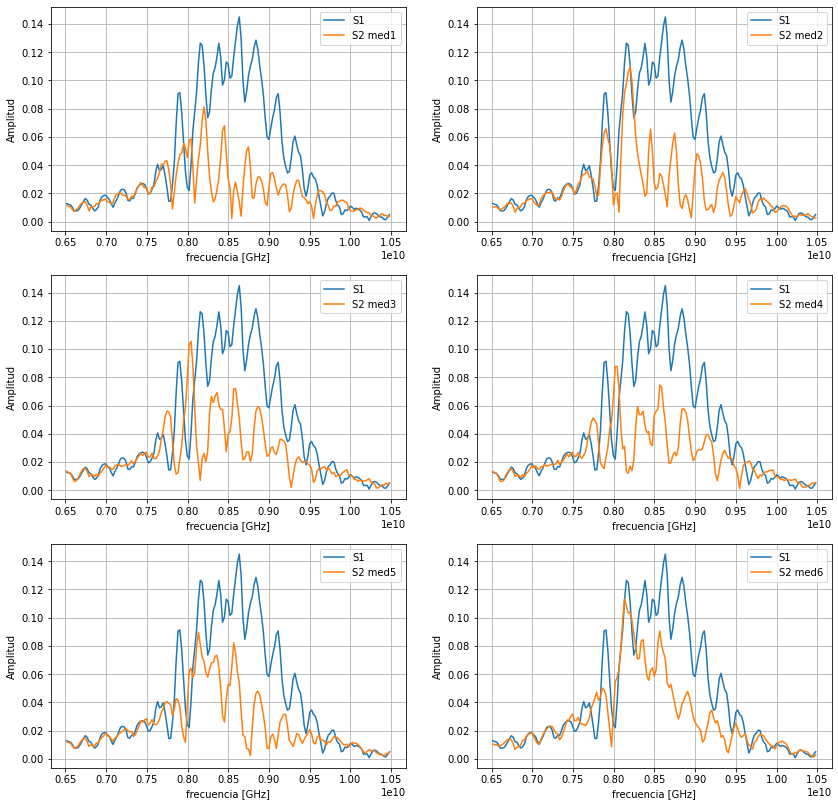

Text(0, 0.5, 'Amplitud')

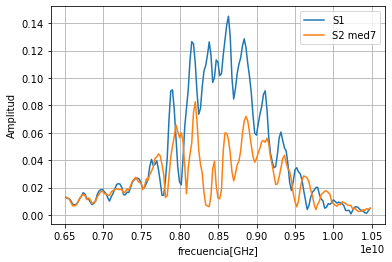

In [6]:
l7_dict ={
    'frecuencia' : f_pos,
    'S1' : S1,
}

L7 = pd.DataFrame(l7_dict)

for i in range(7):
    L7['S2_'+str(i+1)] = S2[i]
print(L7.columns)

L7.to_csv(r'C:\Users\Coraline\Documents\UWB\tesis\Bayesiano\Ajustes\mediciones\L7_Fc8.csv')

L7_liso = L7
L7_rug = L7

#ploteo
fig, ax = plt.subplots(3,2,figsize=(14,14))
for i in range(3):
    for j in range(2):
        ax[i,j].plot(L7['frecuencia'],np.abs(L7['S1']),label='S1')
        k=2*i+j
        ax[i,j].plot(L7['frecuencia'],np.abs(L7['S2_'+str(k+1)]),label='S2 med'+str(med[k]+1))
        ax[i,j].grid()
        ax[i,j].legend(loc='best')
        ax[i,j].set_xlabel('frecuencia [GHz]')
        ax[i,j].set_ylabel('Amplitud')
plt.show()
plt.figure(figsize=(6,4))
plt.plot(L7['frecuencia'],np.abs(L7['S1']),label='S1')
plt.plot(L7['frecuencia'],np.abs(L7['S2_7']),label='S2 med7')
plt.grid()
plt.legend(loc='best')
plt.xlabel('frecuencia[GHz]')
plt.ylabel('Amplitud')

In [20]:
#grilla de valores para MV
%run C:\Users\Coraline\Documents\UWB\tesis\codigos\mv_to_ep.ipynb

##Valores medidos
ep_med = [7.5172+1j*0.67952, 7.367+1j*0.70206, 9.2492+1j*1.3556, 10.5544+1j*1.8849, 11.7172+1j*2.70326, 13.3846+1j*3.4654, 19.2628+1j*5.72864]
mv_med = [0.1166, 0.1142, 0.1494, 0.1716, 0.1904, 0.2160, 0.295]
#profundidad del dieléctrico
H = 9e-2


##Grilla
mv_min, mv_max = 0.75*np.min(mv_med), 1.40*np.max(mv_med)
n_mv = 250
MV = np.linspace(mv_min,mv_max,n_mv)

Sand = 0.12
Clay = 0.17

#metricas de epsilon con error
ep_std = 0.015
ep_teo = mv_to_ep(MV,Sand,Clay,ep_std)['ep']
ep_error = mv_to_ep(MV,Sand,Clay,ep_std)['ep_error']

print('ep min:', np.min(ep_teo))
print('ep max:', np.max(ep_teo))

if np.min(ep_teo)<np.min(ep_med) and np.max(ep_teo)>np.max(ep_med):
    print('epsilon esta en el rango correcto')
else:
    print('epsilon medido no esta en el rango. chequear')

ep min: (4.478696054200926+0.764334231979125j)
ep max: (19.36419466637+4.49952381165j)
epsilon esta en el rango correcto


## Modelo liso

In [21]:
%run C:\Users\Coraline\Documents\UWB\tesis\codigos\R_Fresnel.ipynb

S_optima = np.zeros((len(med),len(S1)), dtype=complex)
ep_optimo = np.zeros((len(med),2),dtype=complex)# 1er col: ep, 2da col_ error_ep
mv_optimo = np.zeros(len(med),dtype=float)

e_mae = np.zeros((len(med),n_mv),dtype=float)
e_rms = np.zeros((len(med),n_mv),dtype=float)

error_mae = np.zeros(len(med), dtype=float)
error_rms = np.zeros(len(med), dtype=float)

inds = []
for i in range(len(med)):
    for j in range(n_mv):
        ep = ep_teo[j]

        R = R_ep_cond(ep,H,f_pos)
        S2teo = S1*R
        
        #Metrica de error
        ## error absoluto medio:
        e_mae[i,j] = np.sum(np.abs(np.abs(S2teo)-np.abs(S2[i,:])))/np.shape(S2)[1]
        ## error cuadrático medio
        e_rms[i,j] = np.sqrt(mean_squared_error(np.abs(S2teo),np.abs(S2[i,:])))

    ind = np.argmin(e_mae[i,:])
    inds.append(ind)
    
    error_mae[i] = e_mae[i,ind]
    error_rms[i] = e_rms[i,ind]

    ep_optimo[i,0] = ep_teo[ind]
    ep_optimo[i,1] = ep_error[ind]
    mv_optimo[i] = MV[ind]
    S_optima[i,:] = S1*R_ep_cond(ep_optimo[i,0],H,f_pos)#*np.exp(1j*2*D*2*np.pi*f_pos/3e8)   

print(inds)
# print(error_mae)
# print(ep_optimo)

[27, 99, 56, 47, 94, 223, 134]


In [22]:
for i in range(7):
    L7_liso['S2Teo_'+str(i+1)] = S_optima[i,:]

print(L7_liso.columns)
L7_liso = L7_liso.drop(['S2_2','S2Teo_2'], axis=1)
print(L7_liso.columns)

Index(['frecuencia', 'S1', 'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S2_5', 'S2_6',
       'S2_7', 'S2Teo_1', 'S2Teo_2', 'S2Teo_3', 'S2Teo_4', 'S2Teo_5',
       'S2Teo_6', 'S2Teo_7'],
      dtype='object')
Index(['frecuencia', 'S1', 'S2_1', 'S2_3', 'S2_4', 'S2_5', 'S2_6', 'S2_7',
       'S2Teo_1', 'S2Teo_3', 'S2Teo_4', 'S2Teo_5', 'S2Teo_6', 'S2Teo_7'],
      dtype='object')


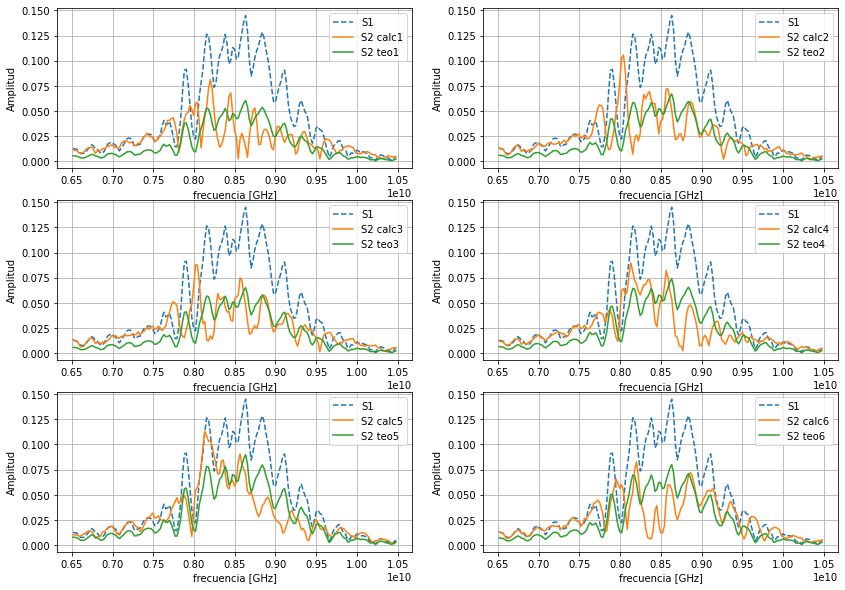

In [23]:
#Me saco de encima la segunda medicion que habia dado mal
fig, ax = plt.subplots(3,2,figsize=(14,10))
for i in range(3):
    for j in range(2):
        k=2*i+j
        ax[i,j].plot(L7_liso['frecuencia'],np.abs(L7_liso['S1']),'--',label='S1')
        ax[i,j].plot(L7_liso['frecuencia'],np.abs(L7_liso.iloc[:,k+2]),label='S2 calc'+str(med[k]+1))
        ax[i,j].plot(L7_liso['frecuencia'],np.abs(L7_liso.iloc[:,k+8]),label='S2 teo'+str(med[k]+1))
        ax[i,j].grid()
        ax[i,j].legend(loc='best')
        ax[i,j].set_xlabel('frecuencia [GHz]')
        ax[i,j].set_ylabel('Amplitud')

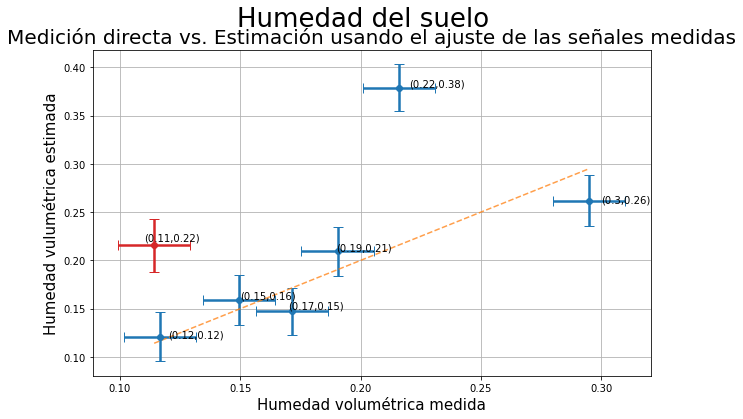

In [24]:
## scatterplot mv_medida vs. mv_estimada
error_mv_med = 0.015 #*mv_med
# calculo el error para mv estimada haciendo derivadas parciales a primer orden
n_fpos = len(f_pos)
auxiliar = np.zeros((n_mv,n_fpos),dtype=complex)

for i in range(n_mv):
  ep1 = ep_teo[i]
  auxiliar[i,:] = S1*R_ep_cond(ep1,H,f_pos)

#print(auxiliar[0,:])

coef = n_mv*len(f_pos)*np.mean(np.mean(np.abs(np.gradient(auxiliar, axis=0))))

error_mv_optimo = coef*error_mae

plt.figure(figsize=(10,6))
plt.errorbar(mv_med[0],mv_optimo[0],xerr= error_mv_med,yerr=error_mv_optimo[0],fmt='o',color='C0', linewidth=2.5,capsize=5)
plt.errorbar(mv_med[1],mv_optimo[1],xerr= error_mv_med,yerr=error_mv_optimo[1],fmt='o',color='C3', linewidth=2.5,capsize=5)
plt.errorbar(mv_med[2:],mv_optimo[2:],xerr= error_mv_med,yerr=error_mv_optimo[2:],fmt='o',color='C0', linewidth=2.5, capsize=5)
for xy in zip(np.round(mv_med,2),np.round(mv_optimo,2)):
  plt.annotate('(%s,%s)' % xy, xy=xy, textcoords='data')
plt.plot([np.min(mv_med), np.max(mv_med)], [np.min(mv_med), np.max(mv_med)],'--C1',alpha=0.75)
plt.grid('on')
plt.xlabel('Humedad volumétrica medida', color = 'k', fontsize = 15)
plt.ylabel('Humedad vulumétrica estimada', color = 'k', fontsize = 15)

plt.title('Medición directa vs. Estimación usando el ajuste de las señales medidas', color = 'k', fontsize = 20)
plt.suptitle('Humedad del suelo',fontsize=26)
plt.show()

## Modelo rugoso

In [25]:
%run C:\Users\Coraline\Documents\UWB\tesis\codigos\Pinel.ipynb

#altura rms de la superficie
#n_rms = 30
#rms_teo = np.linspace(1e-5,1e-1,n_rms)
n_rms = 30
rms_teo = np.linspace(1e-5,1e-1,n_rms)
print('sigma:',np.min(rms_teo)*100,'mm -',np.max(rms_teo)*100,'mm')

S_optima = np.zeros((len(med),len(S1)), dtype=complex)
ep_optimo = np.zeros((len(med),2),dtype=complex)# 1er col: ep, 2da col_ error_ep
mv_optimo = np.zeros(len(med),dtype=float)
rms_optimo = np.zeros((len(med),n_mv),dtype=float)

e_mae = np.zeros((len(med),n_mv,n_rms),dtype=float)
e_rms = np.zeros((len(med),n_mv,n_rms),dtype=float)

error_mae = np.zeros(len(med), dtype=float)
error_rms = np.zeros(len(med), dtype=float)

inds_op = []

for i0 in range(len(med)):
    for i1 in range(n_mv):
        ep = ep_teo[i1]
        for i2 in range(n_rms):
            rms = rms_teo[i2]
            R = Rf_espejo(ep,H,f_pos,rms)
            S2teo = S1*R
                
            #Metrica de error
            ## error absoluto medio:
            e_mae[i0,i1,i2] = np.sum(np.abs(np.abs(S2teo)-np.abs(S2[i0,:])))/np.shape(S2)[1]
            ## error cuadrático medio
            e_rms[i0,i1,i2] = np.sqrt(mean_squared_error(np.abs(S2teo),np.abs(S2[i0,:])))

        ind_rms = np.argmin(e_mae[i0,i1,:])
        # inds_rms.append([i0,i1,ind_rms])
        rms_optimo[i0,i1] = rms_teo[ind_rms]
        
    print('indices para rms: ',ind_rms)
    ind_ep = np.argmin(e_mae[i0,:,ind_rms])
    print('indices para epsilon: ',ind_ep)

    error_mae[i0] = e_mae[i0,ind_ep,ind_rms]
    error_rms[i0] = e_rms[i0,ind_ep,ind_rms]

    ep_optimo[i0,0] = ep_teo[ind_ep]
    ep_optimo[i0,1] = ep_error[ind_ep]
    mv_optimo[i0] = MV[ind_ep]
    

    S_optima[i0,:] = S1*Rf_espejo(ep_optimo[i0,0],H,f_pos,rms_optimo[i0,ind_ep])  

#print('indices para epsilon: ',inds_ep)
#print('indices para rms: ',inds_rms)
# print(error_mae)
# print(ep_optimo)

sigma: 0.001 mm - 10.0 mm
indices para rms:  1
indices para epsilon:  249
indices para rms:  0
indices para epsilon:  99
indices para rms:  0
indices para epsilon:  56
indices para rms:  1
indices para epsilon:  249
indices para rms:  0
indices para epsilon:  94
indices para rms:  0
indices para epsilon:  223
indices para rms:  0
indices para epsilon:  134


In [26]:
for i in range(7):
    L7_rug['S2Teo_'+str(i+1)] = S_optima[i,:]
print(L7_rug.columns)

Index(['frecuencia', 'S1', 'S2_1', 'S2_2', 'S2_3', 'S2_4', 'S2_5', 'S2_6',
       'S2_7', 'S2Teo_1', 'S2Teo_2', 'S2Teo_3', 'S2Teo_4', 'S2Teo_5',
       'S2Teo_6', 'S2Teo_7'],
      dtype='object')


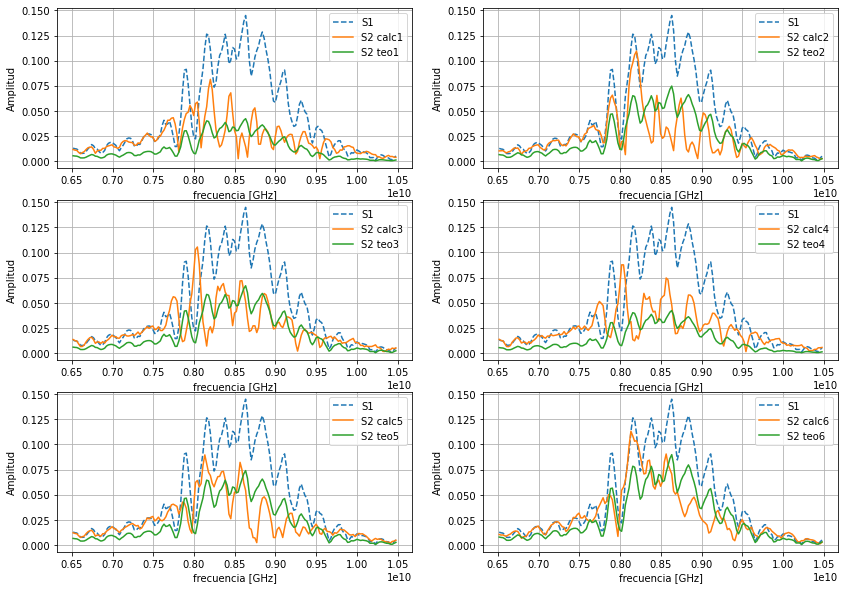

Text(0, 0.5, 'Amplitud')

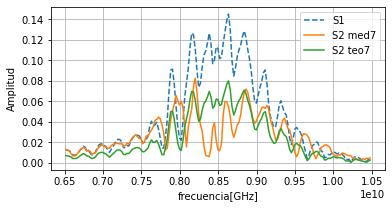

In [27]:
fig, ax = plt.subplots(3,2,figsize=(14,10))
for i in range(3):
    for j in range(2):
        k=2*i+j
        ax[i,j].plot(L7_rug['frecuencia'],np.abs(L7_rug['S1']),'--',label='S1')
        ax[i,j].plot(L7_rug['frecuencia'],np.abs(L7_rug.iloc[:,k+2]),label='S2 calc'+str(med[k]+1))
        ax[i,j].plot(L7_rug['frecuencia'],np.abs(L7_rug.iloc[:,k+9]),label='S2 teo'+str(med[k]+1))
        ax[i,j].grid()
        ax[i,j].legend(loc='best')
        ax[i,j].set_xlabel('frecuencia [GHz]')
        ax[i,j].set_ylabel('Amplitud')
plt.show()
plt.figure(figsize=(6,3))
plt.plot(L7_rug['frecuencia'],np.abs(L7_rug['S1']),'--',label='S1')
plt.plot(L7_rug['frecuencia'],np.abs(L7_rug['S2_7']),label='S2 med7')
plt.plot(L7_rug['frecuencia'],np.abs(L7_rug['S2Teo_7']),label='S2 teo7')
plt.grid()
plt.legend(loc='best')
plt.xlabel('frecuencia[GHz]')
plt.ylabel('Amplitud')

### error
no termino de entender como se calcula y hay que chequearlo con marian, pero... por induccion?? ponele?? aunque sea sirve para poner un numerito al grafico

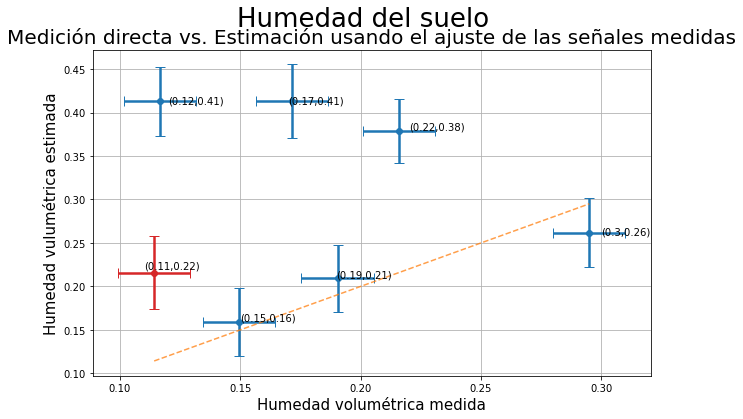

In [28]:
## scatterplot mv_medida vs. mv_estimada
error_mv_med = 0.015 #*mv_med
# calculo el error para mv estimada haciendo derivadas parciales a primer orden
n_fpos = len(f_pos)
auxiliar = np.zeros((n_mv,n_rms,n_fpos),dtype=complex)

for i in range(n_mv):
  ep = ep_teo[i]
  for j in range(n_rms): 
    rms = rms_teo[j]
    auxiliar[i,j,:] = S1*Rf_espejo(ep,H,f_pos,rms)


coef = n_mv*n_rms*len(f_pos)*np.mean(np.mean(np.mean(np.abs(np.gradient(auxiliar, axis=0)))))

error_mv_optimo = coef*error_mae

plt.figure(figsize=(10,6))
plt.errorbar(mv_med[0],mv_optimo[0],xerr= error_mv_med,yerr=error_mv_optimo[0],fmt='o',color='C0', linewidth=2.5,capsize=5)
plt.errorbar(mv_med[1],mv_optimo[1],xerr= error_mv_med,yerr=error_mv_optimo[1],fmt='o',color='C3', linewidth=2.5,capsize=5)
plt.errorbar(mv_med[2:],mv_optimo[2:],xerr= error_mv_med,yerr=error_mv_optimo[2:],fmt='o',color='C0', linewidth=2.5, capsize=5)
for xy in zip(np.round(mv_med,2),np.round(mv_optimo,2)):
  plt.annotate('(%s,%s)' % xy, xy=xy, textcoords='data')
plt.plot([np.min(mv_med), np.max(mv_med)], [np.min(mv_med), np.max(mv_med)],'--C1',alpha=0.75)
plt.grid('on')
plt.xlabel('Humedad volumétrica medida', color = 'k', fontsize = 15)
plt.ylabel('Humedad vulumétrica estimada', color = 'k', fontsize = 15)

plt.title('Medición directa vs. Estimación usando el ajuste de las señales medidas', color = 'k', fontsize = 20)
plt.suptitle('Humedad del suelo',fontsize=26)
plt.show()